<a href="https://colab.research.google.com/github/urieliram/statistical/blob/main/Tarea13.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install sklearn-lvq

In [10]:
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.cluster import MiniBatchKMeans, KMeans
from sklearn.metrics.pairwise import pairwise_distances_argmin
from sklearn_lvq import GlvqModel
from sklearn_lvq.utils import plot2d
from sklearn.mixture import GaussianMixture

In [17]:
#Para acomodar la información si viene por minuto y en registros, 
#df = pd.read_csv('rg1.csv')
## aqui agrupamos por minuto
#df_grouped_multiple = df.groupby(['YEAR','MONTH','DAY','HOUR']).agg({'RG1': ['mean']})
#df_grouped_multiple.columns = ['rg1_mean']
#df_grouped_multiple = df_grouped_multiple.reset_index()
## aquí pivoteamos
#df1 = df_grouped_multiple.pivot(index=['YEAR','MONTH','DAY'], columns='HOUR', values='rg1_mean').dropna()
#print(df1) #df1.to_csv('res.csv')
#df1.columns = [['0','1','2','3','4','5','6','7','8','9','10','11','12','13','14','15','16','17', '18','19', '20', '21', '22', '23']]

In [ ]:
# datos de juguete manufacturados por mi
#dfc = pd.read_csv('cluster.csv')
#print(dfc.columns)
#X = df[['x1','x2','x3','x4','x5','x6','x7','x8','x9','x10','x11']].to_numpy()
#X = df[['x6','x7']].to_numpy()

df = pd.read_csv('rg1_horas.csv')
#print(df1.head)
X = df[['0','1','2','3','4','5','6','7','8','9','10','11','12','13','14','15','16','17','18','19','20','21','22','23']].to_numpy()

#Normalizing the data
#sc = StandardScaler()
#X = sc.fit_transform(X)
#y = sc.fit_transform(Y)

## Crea conjuntos de datos de entrenamiento y prueba
X_train, X_test = train_test_split(X, test_size=0.5,random_state=5) #
for p in X_train:
    plt.plot(p)
    plt.ylabel('radiación solar')
    plt.xlabel('horas')
plt.show()

In [75]:
def print_serie(serie_,title_,):
    fCYAN = '#76ced6' ; LILA = '#777bd4'; VERDE='#17cb49'; LETRASNARA ='#ff8000'; AZUL='#168fff'; OTROAZUL = "b-"; ROJO= "r-";
    fig, ax1 = plt.subplots(figsize=(5,4))
    plt.title(title_,fontsize='x-large',color = LETRASNARA)
    ax1.set_xlabel('horas', color=LETRASNARA, fontsize='large')
    ax1.set_ylabel('radiación solar', color=LETRASNARA, fontsize='large')
    plt.tick_params(colors = LETRASNARA, which='both')
    ax1.spines['bottom'].set_color(LETRASNARA)
    ax1.spines['top'   ].set_color(LETRASNARA) 
    ax1.spines['right' ].set_color(LETRASNARA)
    ax1.spines['left'  ].set_color(LETRASNARA)
    for p in serie_:
        plt.plot(p)
    plt.show()

# **K-means**


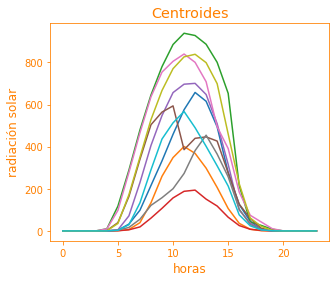

In [76]:
t0 = time.time()
n_clusters = 10
k_means = KMeans(init='k-means++', n_clusters=n_clusters, n_init=10) # una variante MiniBatchKMeans  
k_means = k_means.fit(X_train)
t_batch = time.time() - t0
values  = k_means.cluster_centers_.squeeze()
labels  = k_means.labels_
centers_= k_means.cluster_centers_
#print(labels)
#print('Centroides', centers_)
#print('Exactitud:', k_means.score(X_test))
y_pred  = k_means.predict(X_test)
#print(y_pred)

print_serie(centers_,'Centroides')

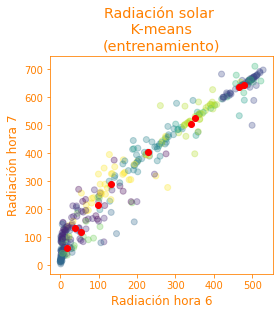

In [77]:
def scatterplot(X_,Y_,tags_,centers_,title_,namefile_ ):
    fig, ax1 = plt.subplots(figsize=(4,4))
    CYAN = '#76ced6' ; LILA = '#777bd4'; VERDE='#17cb49'; LETRASNARA ='#ff8000'; AZUL='#168fff'; OTROAZUL = "b-"; ROJO= "r-";
    for k in centers_:
        x = k[7]; y = k[8]
        plt.plot(x,y,"o",color="red",)
    plt.title(title_,fontsize='x-large',color=LETRASNARA)
    ax1.set_xlabel('Radiación hora 6',  color=LETRASNARA, fontsize='large')
    ax1.set_ylabel('Radiación hora 7',  color=LETRASNARA, fontsize='large')
    plt.scatter(X_, Y_, c=tags_, alpha=0.3)
    plt.tick_params(colors = LETRASNARA, which='both')
    ax1.spines['bottom'].set_color(LETRASNARA)
    ax1.spines['top'   ].set_color(LETRASNARA) 
    ax1.spines['right' ].set_color(LETRASNARA)
    ax1.spines['left'  ].set_color(LETRASNARA)
    plt.savefig(namefile_, transparent=True)
    plt.show()

scatterplot(X_train[:, 7],X_train[:, 8],labels,centers_,'Radiación solar \n K-means \n(entrenamiento)','fig_t13_train')
#scatterplot(  X_test[:, 7], X_test[:, 8],y_pred,centers_,'Radiación solar \n K-means \n(prueba)',       'fig_t13_test')

# **LVQ**

In [144]:
#https://mrnuggelz.github.io/sklearn-lvq/auto_examples/plot_rslvq.html
#https://mrnuggelz.github.io/sklearn-lvq/auto_examples/index.html
#https://mrnuggelz.github.io/sklearn-lvq/modules/generated/sklearn_lvq.GlvqModel.html#sklearn_lvq.GlvqModel
#https://mrnuggelz.github.io/sklearn-lvq/auto_examples/plot_glvq.html#sphx-glr-auto-examples-plot-glvq-py
print('GLVQ:')
#nb_ppc = 100
#toy_data = np.append(
#    np.random.multivariate_normal([0, 0], np.eye(2) / 2, size=nb_ppc),
#    np.random.multivariate_normal([5, 0], np.eye(2) / 2, size=nb_ppc), axis=0)
#toy_label = np.append(np.zeros(nb_ppc), np.ones(nb_ppc), axis=0)

glvq = GlvqModel()
glvq.fit(X_train, labels)
plot2d(glvq, values, labels, 1, 'glvq')

print('classification accuracy:', glvq.score(values, labels))
plt.show()

GLVQ:


ValueError: ignored

# **GaussianMixture**

In [ ]:
#https://scikit-learn.org/stable/auto_examples/cluster/plot_cluster_comparison.html#sphx-glr-auto-examples-cluster-plot-cluster-comparison-py
#https://scikit-learn.org/stable/modules/generated/sklearn.mixture.GaussianMixture.html
gm = GaussianMixture(n_components=2, random_state=0).fit(X_train)
gm.means_ 
xpred = gm.predict(X_test)